In [1]:
from mygo.datasets import *
from mygo.model import *
from mygo.encoder import *
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialization
torch.manual_seed(25565)  # for reproducibility
plt.style.use("dark_background")

In [3]:
encoder = OnePlaneEncoder()

train_data = KGSDataset(
    root="../data/kgs_sgfs",
    train=True,
    game_count=1000,
    encoder=encoder,
)

test_data = KGSDataset(
    root="../data/kgs_sgfs",
    train=False,
    game_count=1000,
    encoder=encoder,
)

In [4]:
# record for plotting
xs = []
train_losses, test_losses = [], []
train_accs, test_accs = [], []

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    train_loss, correct = 0.0, 0.0
    model.train()

    for i, (xs, ys) in enumerate(dataloader):
        optimizer.zero_grad()

        pred = model(xs)
        loss = loss_fn(pred, ys)

        train_loss += loss.item()
        correct += (pred.argmax(1) == ys).type(torch.float).sum().item()

        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"loss: {loss.item():>7f} [{i + 1:>4d}/{batches:>4d}]")

    train_loss /= batches
    accuracy = correct / size * 100
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f"\nTrain: accuracy: {accuracy:>.3f}%, loss: {train_loss:>7f}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    test_loss, correct = 0.0, 0.0
    model.eval()

    with torch.no_grad():
        for xs, ys in dataloader:
            pred = model(xs)
            test_loss += loss_fn(pred, ys).item()
            correct += (pred.argmax(1) == ys).type(torch.float).sum().item()

    test_loss /= batches
    accuracy = correct / size * 100
    test_losses.append(test_loss)
    test_accs.append(accuracy)
    print(f"Test: accuracy: {accuracy:>.3f}%, loss: {test_loss:>7f}")

In [6]:
model = SmallModel(19, 1)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"parameters: {total_params:,}")

SmallModel(
  (conv_stack): Sequential(
    (0): Conv2d(1, 48, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=11552, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=361, bias=True)
  )
)
parameters: 6,192,425


In [7]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters())
batch_size = 128
epoches = 50

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2 * batch_size)

for i in range(1, epoches + 1):
    print(f"Epoch {i}\n{'-' * 25}")
    train_loop(train_loader, model, loss_fn, optimizer)
    torch.save(model.state_dict(), f"../models/small-19x-1p-1000g-{i}e_weights.pt")
    test_loop(test_loader, model, loss_fn)
    xs.append(i)
    print()

Epoch 1
-------------------------
loss: 5.891002 [   1/1464]
loss: 5.599633 [ 501/1464]
loss: 5.233514 [1001/1464]

Train: accuracy: 1.408%, loss: 5.483729
Test: accuracy: 2.911%, loss: 5.221064

Epoch 2
-------------------------
loss: 5.154080 [   1/1464]
loss: 5.084079 [ 501/1464]
loss: 4.966572 [1001/1464]

Train: accuracy: 4.638%, loss: 4.918088
Test: accuracy: 6.098%, loss: 5.076726

Epoch 3
-------------------------
loss: 4.678220 [   1/1464]
loss: 4.709895 [ 501/1464]
loss: 4.141894 [1001/1464]

Train: accuracy: 9.093%, loss: 4.509057
Test: accuracy: 9.091%, loss: 4.987537

Epoch 4
-------------------------
loss: 4.180640 [   1/1464]
loss: 4.316208 [ 501/1464]
loss: 4.469021 [1001/1464]

Train: accuracy: 15.189%, loss: 4.111452
Test: accuracy: 14.186%, loss: 4.684741

Epoch 5
-------------------------
loss: 3.753221 [   1/1464]
loss: 4.037204 [ 501/1464]
loss: 3.677972 [1001/1464]

Train: accuracy: 21.988%, loss: 3.710708
Test: accuracy: 16.075%, loss: 4.530023

Epoch 6
--------

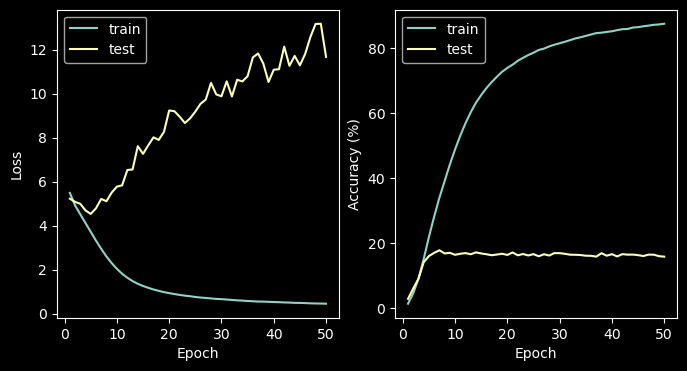

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")

axs[0].plot(xs, train_losses, label="train")
axs[0].plot(xs, test_losses, label="test")
axs[0].legend()
axs[1].plot(xs, train_accs, label="train")
axs[1].plot(xs, test_accs, label="test")
axs[1].legend()

plt.show()